### New Analysis

This analysis is designed to be quicker and more accurate than the previous analysis.

This notebook goes through and visualises the inaccuracies of larger averaging periods and allows the user to modify the averaging period and explore the mappings.

In [324]:
"""
Install the necessary packages
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import scipy
from tqdm import tqdm

# setting to make the plots nicer
import seaborn as sns
sns.set(style="whitegrid")

### Import the Data

lets import the data to have a look at it initially, and modify it slightly.

In [325]:
# import data
solar = pd.read_csv('Data/1_month_solar.csv')

# rename columns
solar.rename(columns={'Datetime':'datetime'}, inplace=True)
solar.rename(columns={'Global Horizontal DH3 (W/m^2)':'power'}, inplace=True)

# convert to datetime
solar['datetime'] = pd.to_datetime(solar['datetime'])

# set datetime as index
solar.set_index('datetime', inplace=True)

# set the starting power value to zero
solar.at[solar.index[0], 'power'] = 0

# add a row for the start of the month at 00:00:00 and at the end at 23:59:59
new_rows = pd.DataFrame(index=[solar.index[0] - timedelta(seconds=60*60*5), solar.index[-1] + timedelta(seconds=60*60*4)], data=0, columns=solar.columns)
solar = pd.concat([new_rows, solar])
solar = solar.sort_index()

# resample so that we have a value for every second
solar = solar.resample('1S').interpolate()

# # resample so that we have a value for every 100 milliseconds
# solar = solar.resample('100L').interpolate()

# remove any negative values
solar['power'].clip(lower=0, inplace=True)

# inspect the data
solar

,power
2017-06-01 00:00:00.000,0.0
2017-06-01 00:00:00.100,0.0
2017-06-01 00:00:00.200,0.0
2017-06-01 00:00:00.300,0.0
2017-06-01 00:00:00.400,0.0
...,...
2017-06-30 23:59:58.600,0.0
2017-06-30 23:59:58.700,0.0
2017-06-30 23:59:58.800,0.0
2017-06-30 23:59:58.900,0.0


### Initial Visualisation

Have an initial look at the data

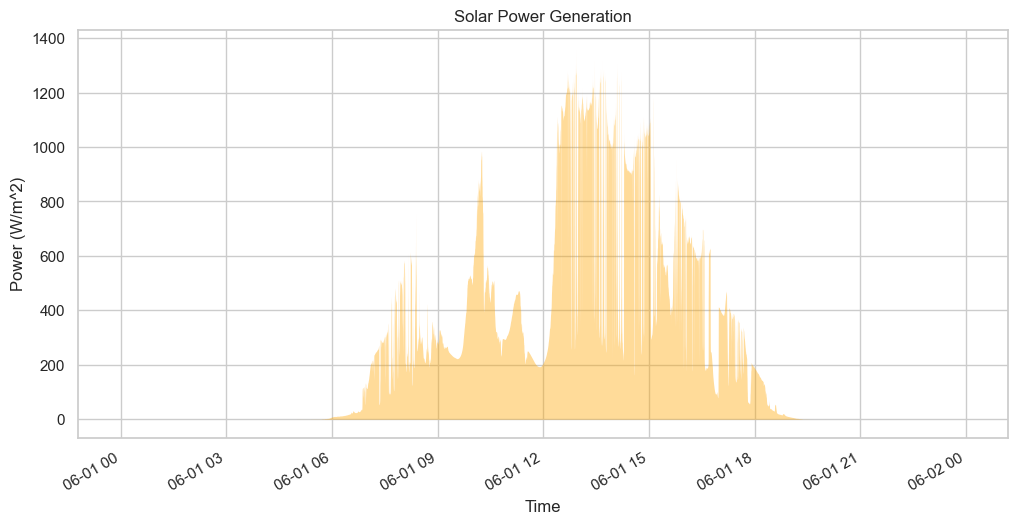

In [326]:
# select the timeframe to look at
day = 1
start_dt = datetime(year = 2017, month = 6, day = day)
end_dt = start_dt + timedelta(days=1)
solar_slice = solar[start_dt:end_dt].copy()

# plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(solar_slice.index, solar_slice['power'], color='orange', alpha=0.4, linewidth=0)
ax.set(xlabel="Time", ylabel="Power (W/m^2)", title="Solar Power Generation")
fig.autofmt_xdate()

### Visualise the Inaccuracy

Lets choose a matching period and visualise the discrepancy between solar generation and a flat demand profile

the solar met 96.01 % of the demand


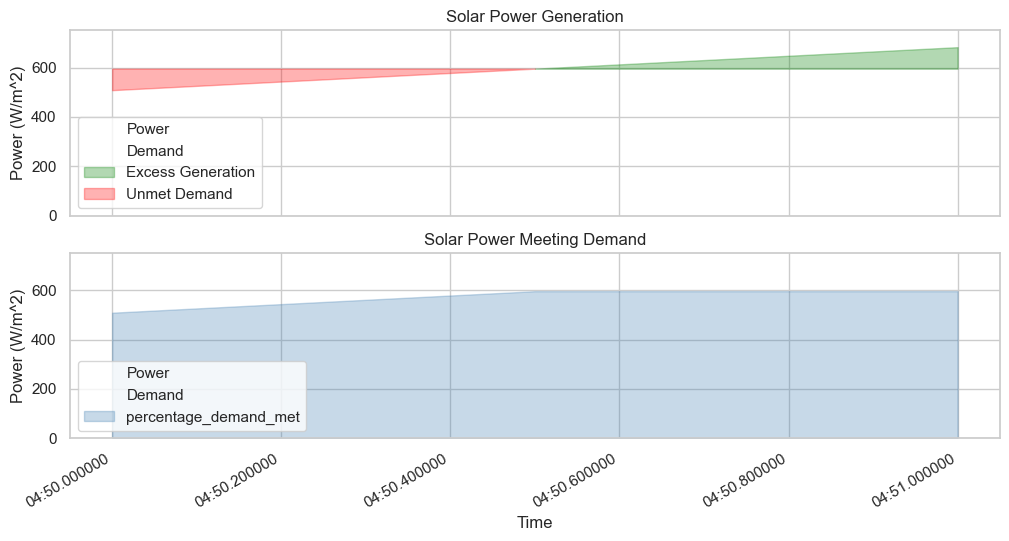

In [327]:
""" Choose the matching period """
"""=========================="""
matching_period = timedelta(seconds=1)
"""=========================="""

start_dt = datetime(year=2017, month=6, day=11, hour=12, minute=4, second=50)
end_dt = start_dt + matching_period
solar_slice = solar[start_dt:end_dt].copy()

# create a column sith the average of the power (called the demand)
solar_slice['demand'] = solar_slice['power'].mean()

# quantify the percentage of demand met by the solar
solar_slice['percentage_demand_met'] = solar_slice['power'] / solar_slice['demand'] * 100
solar_slice['percentage_demand_met'].clip(upper=100, inplace=True)
accuracy = solar_slice['percentage_demand_met'].mean()
print(f"the solar met {accuracy:.2f} % of the demand")

# plot the data
fig, ax = plt.subplots(nrows = 2, figsize=(12, 6))

ax[0].plot(solar_slice.index, solar_slice['power'], color='grey', label='Power', linewidth=0)
ax[0].plot(solar_slice.index, solar_slice['demand'], color='steelblue', label='Demand', linewidth=0)
ax[0].fill_between(solar_slice.index, solar_slice['demand'], solar_slice['power'], where=solar_slice['power'] > solar_slice['demand'], interpolate=True, color='green', alpha=0.3, label='Excess Generation')
ax[0].fill_between(solar_slice.index, solar_slice['demand'], solar_slice['power'], where=solar_slice['power'] < solar_slice['demand'], interpolate=True, color='red', alpha=0.3, label='Unmet Demand')
ax[0].set(xlabel="Time", ylabel="Power (W/m^2)", title="Solar Power Generation")
ax[0].set_ylim(0, solar_slice['power'].max()*1.1)
ax[0].legend()

ax[1].plot(solar_slice.index, solar_slice['power'], color='grey', label='Power', linewidth=0)
ax[1].plot(solar_slice.index, solar_slice['demand'], color='steelblue', label='Demand', linewidth=0)
ax[1].fill_between(solar_slice.index, 0, solar_slice['percentage_demand_met']*solar_slice['demand'].mean()/100, color='steelblue', alpha=0.3, label='percentage_demand_met')
ax[1].set(xlabel="Time", ylabel="Power (W/m^2)", title="Solar Power Meeting Demand")
ax[1].set_ylim(0, solar_slice['power'].max()*1.1)
ax[1].legend()

fig.autofmt_xdate()




### Perform the analysis

Perform the matching analysis for each matching period within the months worth of solar data

In [328]:
# print the matching period that we are using for the current analysis
print(f'Matching Period: {matching_period}\n')

# set the starting date
year = 2017
month = 6

# create a list to store the results
results = []

# loop through each day in the month
for day in tqdm(range(1, 31)):
    
    # filter to the day
    start_dt = datetime(year=year, month=month, day=day)
    end_dt = start_dt + timedelta(days=1)
    solar_slice = solar[start_dt:end_dt].copy()
    sliced_array = solar_slice['power'].values

    # determine how many matching periods there are in the day
    n_matching_periods = int((end_dt - start_dt).total_seconds() / matching_period.total_seconds())

    # loop through each matching period
    for i in range(n_matching_periods):
        
        # filter the array to the matching period
        start_idx = i * int(matching_period.total_seconds())
        end_idx = start_idx + int(matching_period.total_seconds())
        matching_period_array = sliced_array[start_idx:end_idx]

        # create the flat demand array
        demand_array = np.full_like(matching_period_array, matching_period_array.mean())

        # calculate the percentage of demand met by the solar
        if np.sum(demand_array) == 0:
            # if there is no solar generation then skip
            continue
        else:
            percentage_demand_met = (matching_period_array / demand_array) * 100
            percentage_demand_met = np.clip(percentage_demand_met, 0, 100)
            # calculate the accuracy
            accuracy = percentage_demand_met.mean()
            weight = np.sum(demand_array)

        # store the results
        results.append({
            'datetime': start_dt + timedelta(seconds=i*int(matching_period.total_seconds())),
            'accuracy': accuracy,
            'weight': weight
        })

done = True

Matching Period: 0:00:01



100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


### Visualise the Results

visualise the results

/var/folders/hp/vg51f9ss37n33r4qdw2s_1880000gn/T/ipykernel_10126/3784919351.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


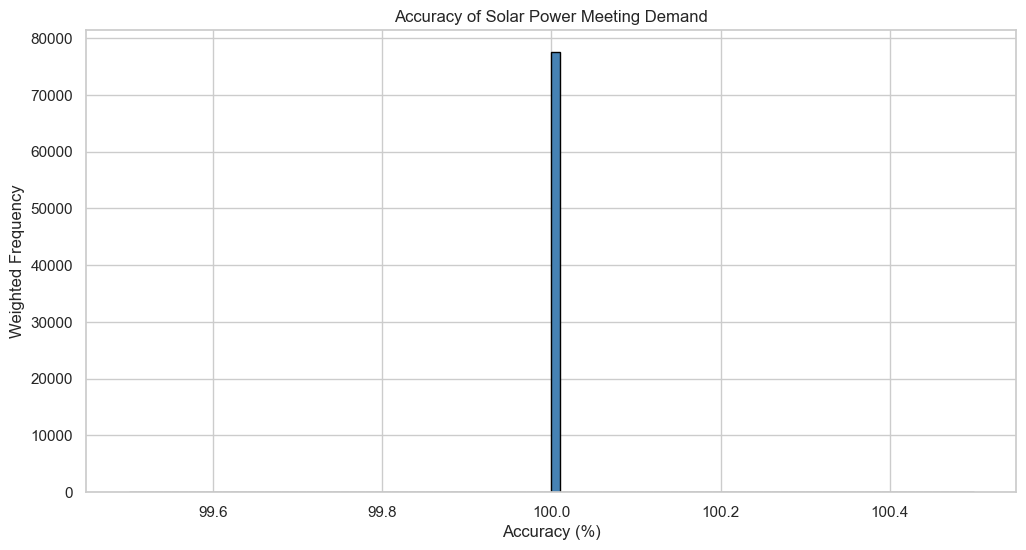

In [329]:
# get the results into an array
accuracy_array = np.array([result['accuracy'] for result in results])
weight_array = np.array([result['weight'] for result in results])

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(accuracy_array, bins=100, weights=weight_array, color='steelblue', edgecolor='black')
ax.set(xlabel="Accuracy (%)", ylabel="Weighted Frequency", title="Accuracy of Solar Power Meeting Demand")

fig.show()

### Probabilistic Analysis

lets explore the data and perform a probabilistic analysis

P90 Done | 100.0
P50 Done | 100.0
P90: 100.00
P50: 100.00


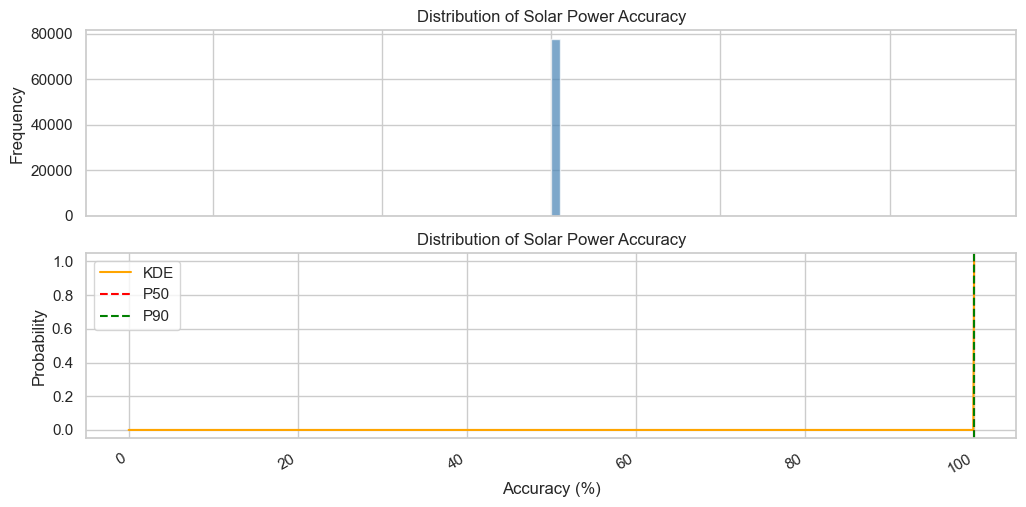

In [330]:
# define whether the analysis is weighted or not
weighted = True

# fit a kde to the data
kde = scipy.stats.gaussian_kde(accuracy_array, weights=weight_array if weighted else None)

# create a range of values to evaluate the kde at
x = np.linspace(0, 100, 1000)
y = kde(x)

# normalise the kde
y = y / y.sum()

# determine the P90 and P50 values from the kde
count = 0
for n in range(len(y)):
    count += y[n]
    if count >= 0.1:
        p90 = x[n]
        print(f"P90 Done | {p90} %")
        break
    if n == len(y):
        p90 = 100
        print(f"P90 Done | {p90} %")
count = 0
for n in range(len(y)):
    count += y[n]
    if count >= 0.5:
        p50 = x[n]
        print(f"P50 Done | {p50}")
        break
    if n == len(y):
        p50 = 100
        print(f"P50 Done | {p50}")

# plot the kde and the histogram
fig, ax = plt.subplots(nrows=2, figsize=(12, 6))

ax[0].hist(accuracy_array, weights=weight_array if weighted else None, bins=100, color='steelblue', alpha=0.7)
ax[0].set(xlabel="Accuracy (%)", ylabel="Frequency", title="Distribution of Solar Power Accuracy")

ax[1].plot(x, y, color='orange', label='KDE')
ax[1].axvline(p50, color='red', linestyle='--', label='P50')
ax[1].axvline(p90, color='green', linestyle='--', label='P90')
ax[1].set(xlabel="Accuracy (%)", ylabel="Probability", title="Distribution of Solar Power Accuracy")
ax[1].legend()
fig.autofmt_xdate()

